In [1]:
#external packages
import numpy as np
import math
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import time
from numpy.lib.recfunctions import append_fields
from astropy.cosmology import FlatLambdaCDM,Planck15
from matplotlib.backends.backend_pdf import PdfPages
import sys
%load_ext autoreload

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import sys
sys.path.append('/home/almhatre/data')


In [2]:
#internal
from AGNclustering.kde import weighted_gaussian_kde
import AGNclustering.projected_correlation_functions as w
import AGNclustering.wppi_projected_correlation_functions as wz
import AGNclustering.BASS_randoms as rand
from AGNclustering.utils import wp_d1d2,wp_dd
from AGNclustering.wppi_utils import wppi_d1d2,wppi_dd,ratio_error

Assumes BASS catalog, galaxy catalogs, and sensitivity maps are in folder `data_directory'

## Initialize the cosmology
see here for reference: http://docs.astropy.org/en/stable/cosmology/

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

## Read in AGN catalog
From Swift/BAT AGN Spectroscopic Survey: Local, hard X-ray selected

In [4]:
data_directory = '/home/almhatre/data/BASS/'
cat = Table.read(data_directory + 'data_dr2.csv',format='csv')
agnt =np.array(cat)

List the names of the columns in the catalog. For the clustering code, you need at least 'ra', 'dec', and 'z'

In [5]:
agnt.dtype.names

('col0',
 'bat_index',
 'Counterpart',
 'Type',
 'z',
 'Mbh',
 'Method',
 'Edd_rat',
 'L_edd',
 'L_bol',
 'NH',
 'L210',
 'ra',
 'dec',
 'L14195',
 'AGN',
 'flux',
 'Snu_1',
 'Snu_6',
 'Morphology',
 'log_Ms',
 'Lir_sf')

Limit catalog to preferred luminosity & redshift range  
Here, we choose AGN with X-ray luminosities $>10^{42.5}$ erg/s, in the redshift range $0.01<z<0.1$:

In [6]:
agn = agnt[ (agnt['L210']>42.5) & (agnt['z']>.01)&(agnt['z']<=.1) ]

In [7]:
len(agn) #gives number of AGN in catalog (length of the array)

724

## Read in galaxy catalog

In [8]:
t = Table.read(data_directory +'2mrs_noAGN.csv',format='csv')
gal =np.array(t)

In [9]:
gal.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'cdist')

In [10]:
gal=gal[(gal['z']>.01)&(gal['z']<=.1)] #Limit redshifts to same range as AGN
len(gal)

38567

## Plot positions of AGN, galaxies on the sky

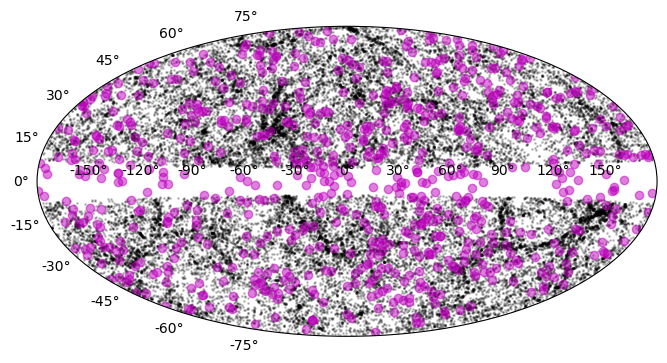

In [11]:
ra1 = coord.Angle(agn['ra']*u.degree)
ra1 = ra1.wrap_at(180*u.degree)
dec1 = coord.Angle(agn['dec']*u.degree)

ra2 = coord.Angle(gal['l']*u.degree)
ra2 = ra2.wrap_at(180*u.degree)
dec2 = coord.Angle(gal['b']*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
#y1 = coord.Angle(8*u.degree)
#y2 = coord.Angle(-8*u.degree)

ax.scatter(ra2.radian, dec2.radian,1,color='k',alpha=.2)
ax.scatter(ra1.radian, dec1.radian,color='m',alpha=.5)


## Make random catalogs

Using sensitivity maps for 70 month survey


Set MJD-OBS to 53355.002572 from DATE-OBS.
Set MJD-END to 55469.117384 from DATE-END'. [astropy.wcs.wcs]


number of randoms: 56092


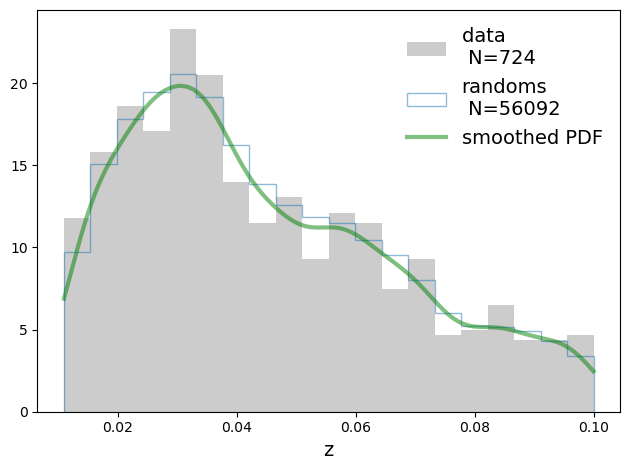

In [12]:
arand = rand.genrand(agn,100,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=True,\
                     data_path=data_directory,plot=True,plot_filename=None)

#100: 100X randoms as AGN

In [13]:
arand.dtype.names

('z', 'ra', 'dec', 'l', 'b', 'flux', 'cdist')

number of randoms: 887041


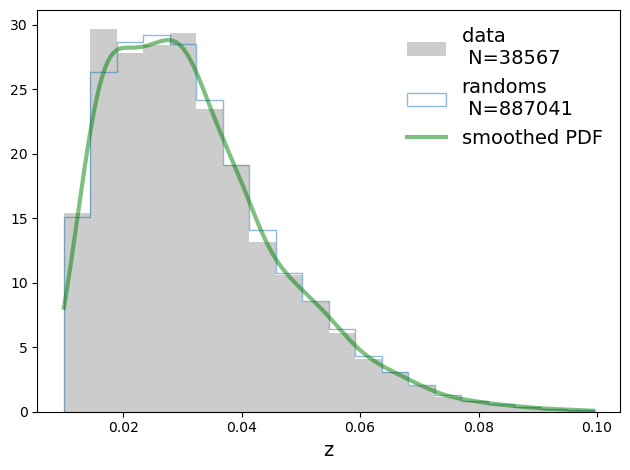

In [14]:
grandt = rand.genrand(gal,23,cosmo,width=.2,scoords='galactic',use_BASS_sens_map=False,\
                     plot=True,plot_filename=None)

# exclude galactic plane:
gal = gal[(gal['b']<-8) | (gal['b']>8)]
grand = grandt[(grandt['b']<-8) | (grandt['b']>8)]

## specify clustering parameters
pi_max: maximum seperation in redshift space that we integrate to (max length we average over)  
nbins: number of projected spatial bins

In [15]:
AGN_highmass = agn[(agn['Mbh']>7.81) ]
AGN_lowmass = agn[(agn['Mbh']<=7.81)]

In [16]:
pimax=40
pibins = np.logspace(0,np.log10(40),6, dtype=int)
linpibins = np.arange(1,41,1)



# to compare better with pibins: 6 logspaced bins
binsmod = np.logspace(0,np.log10(40),6,dtype=int)
binsmod = binsmod.astype(dtype=float)
binsmod = np.insert(binsmod, 0, 0.1)


linbins = np.arange(0,41,1, dtype=float)
linbins[0] = 0.01


nbins = 10
bins = np.logspace(-1, np.log10(40), nbins + 1)

## Autocorrelate AGN

Using the Landy-Szalay estimator for the correlation function:   

$\xi(r_{p},\pi) = \frac{DD - 2DR + RR}{RR}$   
DD: # data-data pairs   
DR: # data-random pairs    
RR: # random-random pairs   

$w_{p} = 2 \int^{\pi_{\rm{max}}}_{0} \xi(r_{p},\pi) d\pi$

$r_p$: spatial separation perpendicular to the line of sight   
$\pi$: spatial separation parallel to the line of sight   

In [146]:
rp,wp_aa,wp_aa_err,cov = w.auto_wp(agn, arand, bins, pimax, 5, estimator='L')
# the 5 refers to the square root of the number of jackknife samples used to estimate the errors


using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.225 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.199 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.186 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.171 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.194 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.189 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.201 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.198 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.198 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.....100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.199 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.195 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 16,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.189 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.208 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.222 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.210 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.207 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.198 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.189 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.192 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.196 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.192 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.193 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.014 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.192 secs


Plot

Text(0.5, 1.0, 'AGN ACF')

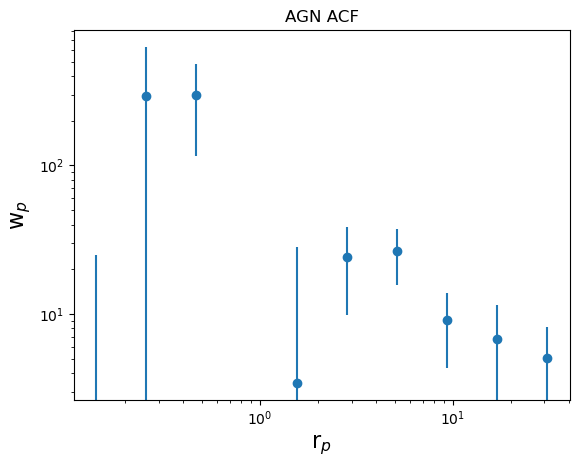

In [147]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_aa,yerr=wp_aa_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN ACF')

There's a signal, but the errors are pretty large

## Cross-correlate AGN with galaxies

$\xi(r_{p},\pi) = \frac{D_{1}D_{2} - D_{1}R_{2} - D_{2}R_{1} + R_{1}R_{2}}{R_{1}R_{2}}$   

1: AGN   
2: Galaxies

In [148]:
t1=time.time()
rp,wp_ag,wp_ag_err,Mag= w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='L')
t = time.time() - t1

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.068 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.105 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.088 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.083 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.084 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.082 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.107 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.086 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.084 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

In [149]:
print('took ',str(t/60),' minutes')

took  2.8721060236295064  minutes


Text(0.5, 1.0, 'AGN XCF')

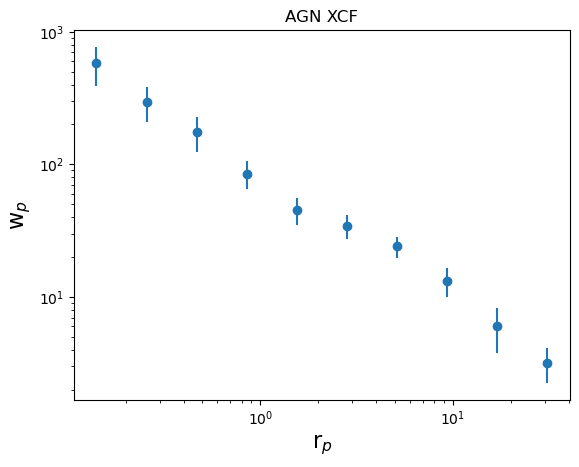

In [150]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')

better!

Try another estimator (Davis & Peebles):
$\xi(r_{p},\pi) = \frac{D_{1}D_{2}}{D_{1}R_{2}} - 1$   

In [151]:
#%%timeit
t1=time.time()
rp,wp_agp,wp_agp_err,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pimax=pimax, m=5, estimator='P')
t = time.time() - t1

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.105 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.102 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.089 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.108 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs


In [152]:
print('took ',str(t),' seconds')

took  10.121694326400757  seconds


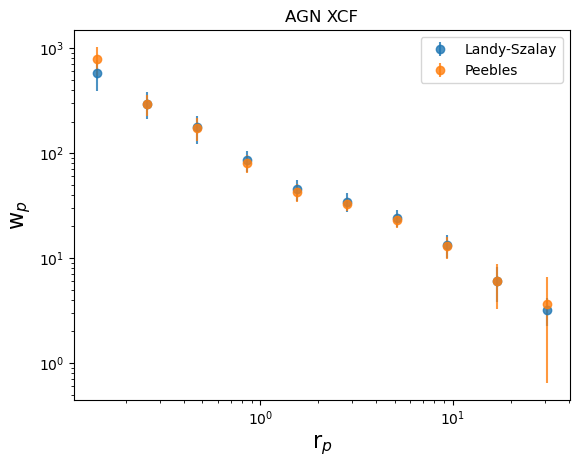

In [153]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(rp,wp_ag,yerr=wp_ag_err,fmt='o',label='Landy-Szalay',alpha=0.8)
plt.errorbar(rp,wp_agp,yerr=wp_agp_err,fmt='o',label='Peebles',alpha=0.8)
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()

In [154]:
# Collapsing 2d correlation function along rp - Auto_wp Landay-Szalay
%autoreload 2
pi,wppi_aa,wppi_aa_err,cov = wz.auto_wppi(agn, arand, bins, pibins, pimax, 5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.208 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%..100% done. Time taken =  0.003 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.185 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.190 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.196 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.011 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.220 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.191 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.191 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.186 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.178 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.194 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 16,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.002 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.188 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.196 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.202 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.207 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,16,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.196 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.169 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.003 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.200 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.014 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.202 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.002 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.218 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.191 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,17,9.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.001 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.197 secs


Text(0.5, 1.0, 'Autocorrelation: Log Binned')

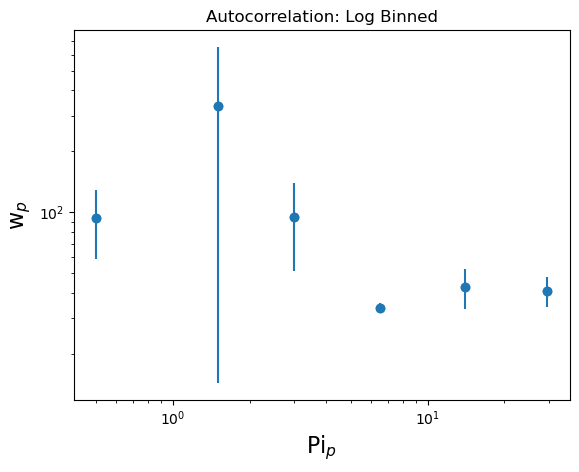

In [155]:
plt.yscale("log")
plt.xscale("log")
plt.scatter(pi,wppi_aa, alpha=0.8)
plt.errorbar(pi,wppi_aa,yerr=wppi_aa_err,fmt='o')
plt.xlabel('Pi$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Autocorrelation: Log Binned')

In [67]:
# Landay-Szalay 6 pi bins Wp(pi)
%autoreload 2
pi, wppi_ls, wppi_ls_err, cov = wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.156 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.015 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.137 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.133 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.134 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.133 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.121 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%..100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.161 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.003 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.136 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.142 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.155 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.157 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.142 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.153 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.131 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

In [18]:
# Landay Szalay 6 rp bins Wp(rp)
rp_mod,wp_ag_mod,wp_ag_mod_err,Mag= w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.038 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.081 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.108 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.099 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.087 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.054 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.111 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.010 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.094 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

In [80]:
# Landay-Szalay 40 rp bins Wp(rp)
rp_lin,wp_lin_ls,wp_lin_ls_err,Mag= w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=linbins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.157 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.057 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.065 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.152 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.015 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.133 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.167 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.061 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,9.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%........

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.144 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.131 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.119 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%......100% done. Time taken =  0.023 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.059 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.016 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.037 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.122 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.128 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%......

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.136 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%......

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.039 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.134 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.157 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.004 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%......

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.167 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%......

In [17]:
# Landay-Szalay 40 pi bins Wp(pi)
pi_lin, wppi_lin_ls= wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=linpibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.008 sec
Using AVX kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.097 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.182 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.

1600


In [18]:
# Landay-Szalay 40 pi bins Wp(pi)
api_lin, awppi_lin_ls= wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=bins, pibins=linpibins, pimax=pimax, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%......

379


Text(0.5, 1.0, 'Clustering of pi vs rp 40 bins of rp/pi')

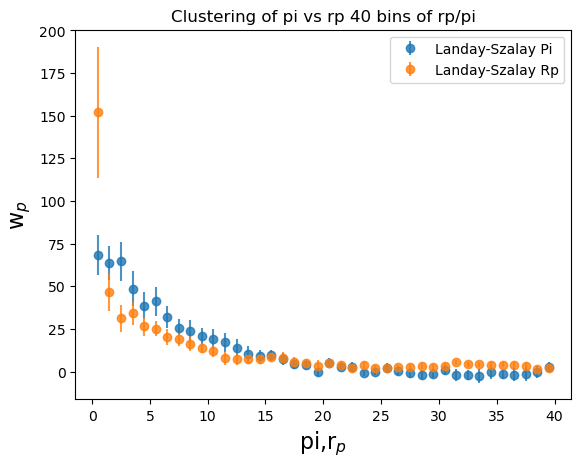

In [64]:
plt.errorbar(pi_lin,wppi_lin_ls,yerr=wppi_lin_ls_err,fmt='o',label='Landay-Szalay Pi',alpha=0.8)
plt.errorbar(rp_lin,wp_lin_ls,yerr=wp_lin_ls_err,fmt='o',label='Landay-Szalay Rp',alpha=0.8)
plt.legend()
plt.xlabel('pi,r$_{p}$',fontsize=16)
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Clustering of pi vs rp 40 bins of rp/pi')

In [19]:
# Peebles estimator 6 pi bins Wp(pi)
%autoreload 2
pi,wppi_p,wppi_p_err,cov = wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=pibins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.073 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.160 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.055 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.153 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.157 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.026 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.159 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.053 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.172 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.155 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.152 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.137 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.167 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.144 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.131 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.156 secs


In [20]:
# Peebles estimator 6 rp bins Wp(rp)
rp_mod,wp_agp_mod,wp_agp_err_mod,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=binsmod, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.097 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.091 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.009 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.101 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.103 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.108 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.105 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.114 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.093 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,20,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.092 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.052 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.111 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.117 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.095 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.096 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.090 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.......100% done. Time taken =  0.108 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.098 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.050 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.100 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,20,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.104 secs


In [89]:
# Peebles estimator 40 pi bins Wp(pi)
%autoreload 2
pi_lin,wppi_lin_p,wppi_lin_p_err,cov = wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=linbins, pibins=linpibins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.147 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.133 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.002 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.140 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.136 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.144 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.163 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.136 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.152 secs


In [90]:
# Peebles estimator 40 rp bins Wp(rp)
rp_lin,wp_lin_p,wp_lin_p_err,Mag = w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=linbins, pimax=pimax, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.154 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.046 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.133 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.147 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.143 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.048 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.145 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.042 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%...100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.134 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.135 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.007 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.149 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.146 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.008 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.051 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.162 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.144 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,17,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.043 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.139 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.161 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.004 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.044 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.018 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.040 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.141 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.005 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.041 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.138 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.049 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.158 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 19,18,9.  Time taken =   0.006 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.001 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 20,19,10.  Time taken =   0.045 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.150 secs


Text(0.5, 1.0, 'Linearly binned Peebles')

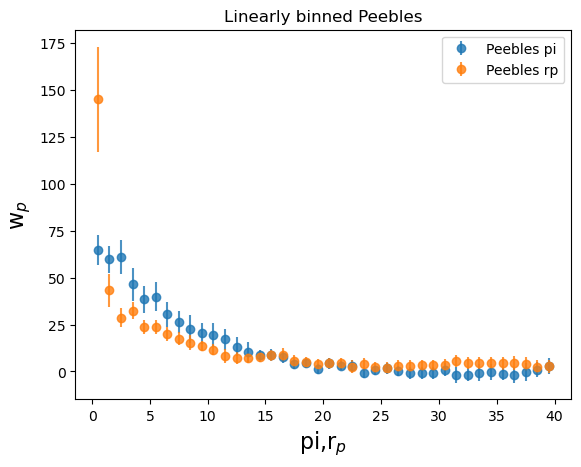

In [134]:
plt.errorbar(pi_lin,wppi_lin_p,yerr=wppi_lin_p_err,fmt='o',label='Peebles pi',alpha=0.8)
plt.errorbar(rp_lin,wp_lin_p,yerr=wp_lin_p_err,fmt='o',label='Peebles rp',alpha=0.8)
plt.legend()
plt.xlabel('pi,r$_{p}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Linearly binned Peebles')

In [66]:
ratiobins=np.arange(0,13,1,dtype=float)
ratiobins[0]=0.01
pimax_ratio=12
ratiopibins=np.arange(1,13,1)

In [50]:
pi_ratio,wppi_p_r,wppi_p_err_r,cov=wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=ratiobins, pibins=pibins_ratio, pimax=pimax_ratio, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.155 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.084 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.090 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.079 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.033 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.094 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.082 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.085 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.076 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


In [51]:
rp_ratio,wp_agp_mod_r,wp_agp_err_mod_r,cov=w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=ratiobins, pimax=pimax_ratio, m=5, estimator='P')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.169 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs


Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.079 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.011 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.029 secs


6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.087 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs


12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.079 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs


13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.013 sec
0%100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs


14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.071 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.082 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.102 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.081 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.096 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs


23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs


24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs


25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.095 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


In [57]:
pi_ratio,wppi_ls_r,wppi_ls_err_r,cov=wz.cross_wppi(d1=agn, d2=gal, r1=arand, r2=grand, bins=ratiobins, pibins=pibins_ratio, pimax=pimax_ratio, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.021 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.170 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%....

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.074 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.095 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.008 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.081 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.021 sec
0%.........10%.........20%.........30%.........40%....

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.079 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.023 sec
0%.........10%.........20%.........30%.........40%....

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.027 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%....

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.098 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.021 sec
0%.........10%.........20%.........30%.........40%....

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.077 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.095 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.073 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.021 sec
0%.........10%.........20%.........30%.........40%....

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.082 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.023 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.079 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%....

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%....

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.076 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.099 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.014 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.084 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%....

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.097 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.016 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.103 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.010 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%........100% done. Time taken =  0.017 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.087 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.....

In [58]:
rp_ratio,wp_ag_mod_r,wp_ag_mod_err_r,cov=w.cross_wp(d1=agn, d2=gal, r1=arand, r2=grand, bins=ratiobins, pimax=pimax_ratio, m=5, estimator='L')

using LCDM cosmology: Om0=.3, H0=70


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.158 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.024 sec
0%.........10%.........20%.........30%.........40%....

Using  25  jacknife samples
1 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.023 sec
0%.........10%.........20%.........30%.........40%....

2 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%....

3 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 31,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.091 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

4 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.009 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.023 sec
0%.........10%.........20%.........30%.........40%....

5 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%....

6 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.082 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%....

7 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.073 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

8 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,30,33.  Time taken =   0.011 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.092 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.021 sec
0%.........10%.........20%.........30%.........40%....

9 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.072 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

10 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.019 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%...100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%.........50%.........6

11 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.084 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.020 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

12 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.011 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.104 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.019 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.023 sec
0%.........10%.........20%.........30%.........40%....

13 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 30,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%....100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........

14 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.012 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.097 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.028 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

15 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.080 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

16 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,32.  Time taken =   0.014 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.087 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.014 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

17 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.019 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.023 sec
0%.........10%.........20%.........30%.........40%....

18 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,29,33.  Time taken =   0.011 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.010 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,32,33.  Time taken =   0.097 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.025 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.018 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

19 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.075 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.022 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.013 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%....

20 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.013 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.101 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.020 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.021 sec
0%.........10%.........20%.........30%.........40%....

21 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.015 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.087 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

22 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.091 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.028 sec
0%.........10%.........20%.........30%.........40%....

23 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.016 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.006 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.092 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.024 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.017 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,34.  Time taken =   0.022 sec
0%.........10%.........20%.........30%.........40%....

24 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.007 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.009 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.027 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

25 / 25


In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 32,31,33.  Time taken =   0.018 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.012 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.008 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 33,33,33.  Time taken =   0.083 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.021 secs
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.015 sec
In gridlink_mocks_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 34,33,34.  Time taken =   0.017 sec
0%.........10%.........20%.........30%.........40%....

In [59]:
ratio_p_err_r=ratio_error(wppi_p_r,wp_agp_mod_r,wppi_p_err_r,wp_agp_err_mod_r)
ratio_ls_err_r=ratio_error(wppi_ls_r,wp_ag_mod_r,wppi_ls_err_r,wp_ag_mod_err_r)
ratio_p_err=ratio_error(wppi_p,wp_agp_mod,wppi_p_err,wp_agp_err_mod)
ratio_ls_err=ratio_error(wppi_ls,wp_ag_mod,wppi_ls_err,wp_ag_mod_err)

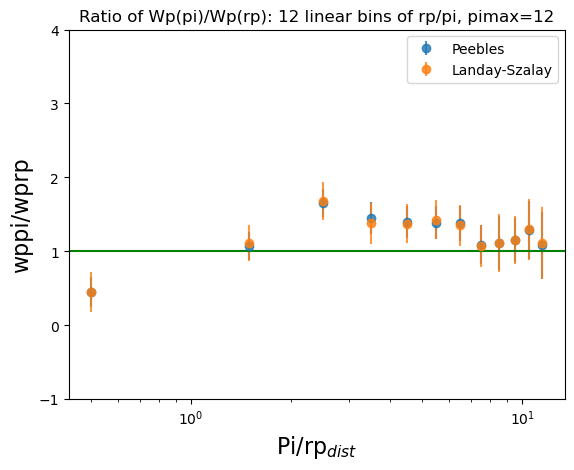

In [86]:
plt.xscale("log")
plt.errorbar(pi_ratio, wppi_p_r/wp_agp_mod_r,yerr=ratio_p_err_r,fmt='o',label='Peebles',alpha=0.8)
plt.errorbar(pi_ratio, wppi_ls_r/wp_ag_mod_r,yerr=ratio_ls_err_r,fmt='o',label='Landay-Szalay',alpha=0.8)
plt.ylim([-1,4])
plt.axhline(1,color='g')
plt.legend()
plt.xlabel('Pi/rp$_{dist}$',fontsize=16)
plt.ylabel('wppi/wprp',fontsize=16)
plt.title('Ratio of Wp(pi)/Wp(rp): 12 linear bins of rp/pi, pimax=12')
plt.savefig('/home/almhatre/data/wppi_ratio_wprp_12linearbins.pdf',format='pdf')

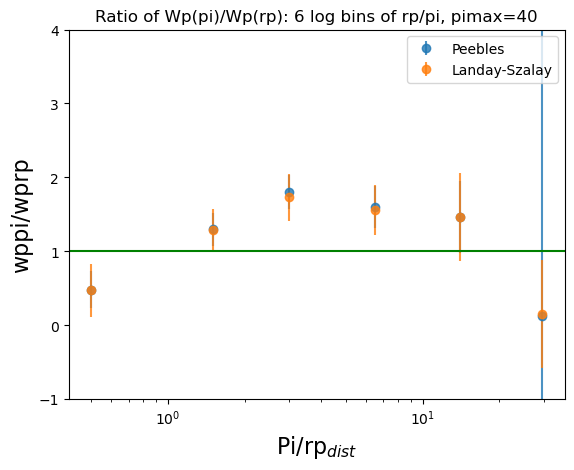

In [87]:
plt.xscale("log")
plt.errorbar(pi, wppi_p/wp_agp_mod,yerr=ratio_p_err,fmt='o',label='Peebles',alpha=0.8)
plt.errorbar(pi, wppi_ls/wp_ag_mod,yerr=ratio_ls_err,fmt='o',label='Landay-Szalay',alpha=0.8)
plt.axhline(1,color='g')
plt.ylim([-1,4])
plt.legend()
plt.xlabel('Pi/rp$_{dist}$',fontsize=16)
plt.ylabel('wppi/wprp',fontsize=16)
plt.title('Ratio of Wp(pi)/Wp(rp): 6 log bins of rp/pi, pimax=40')

Text(0.5, 1.0, 'Clustering of pi vs rp')

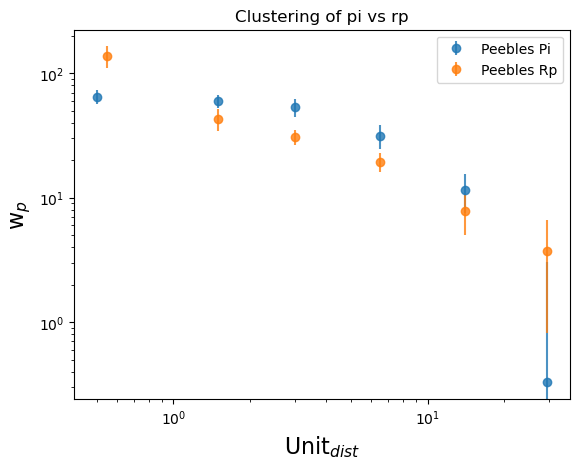

In [169]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(pi,wppi_p,yerr=wppi_p_err,fmt='o',label='Peebles Pi',alpha=0.8)
plt.errorbar(rp_mod,wp_agp_mod,yerr=wp_agp_err_mod,fmt='o',label='Peebles Rp',alpha=0.8)
# plt.errorbar(rp,wp_agp,yerr=wp_agp_err,fmt='o',label='10 Bins Peebles rp',alpha=0.8)
plt.legend()
plt.xlabel('Unit$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Clustering of pi vs rp')

Text(0.5, 1.0, 'Clustering of pi vs rp')

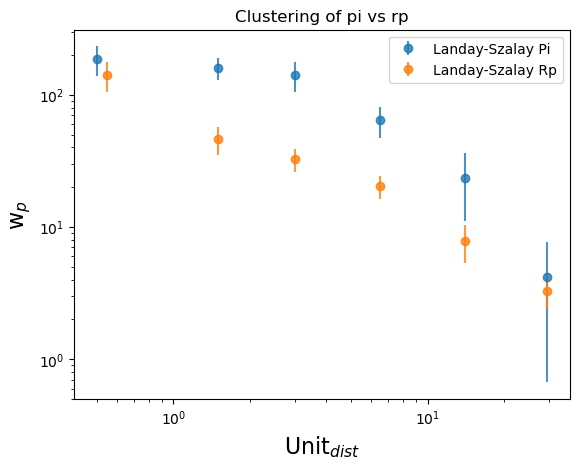

In [159]:
plt.yscale("log")
plt.xscale("log")
plt.errorbar(pi,wppi_ls,yerr=wppi_ls_err,fmt='o',label='Landay-Szalay Pi',alpha=0.8)
plt.errorbar(rp_mod,wp_ag_mod,yerr=wp_ag_mod_err,fmt='o',label='Landay-Szalay Rp',alpha=0.8)
plt.legend()
plt.xlabel('Unit$_{dist}$',fontsize=16, )
plt.ylabel('w$_{p}$',fontsize=16)
plt.title('Clustering of pi vs rp')

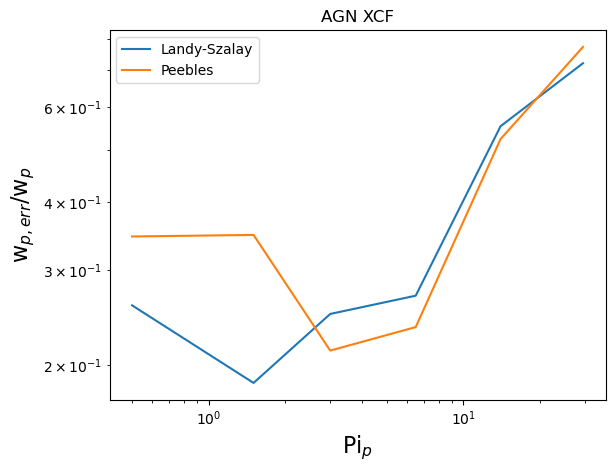

In [57]:
plt.yscale("log")
plt.xscale("log")
plt.plot(pi,wppi_ls_err/wppi_ls,label='Landy-Szalay')
plt.plot(pi,wppi_p_err/wppi_p,label='Peebles')
plt.xlabel('Pi$_{p}$',fontsize=16)
plt.ylabel('w$_{p,err}$/w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()

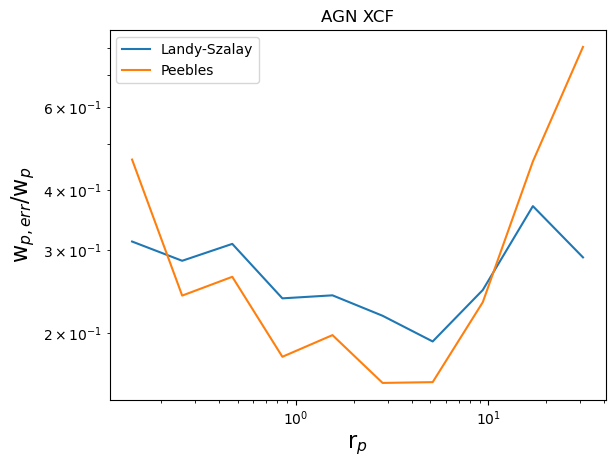

In [72]:
plt.yscale("log")
plt.xscale("log")
plt.plot(rp,wp_ag_err/wp_ag,label='Landy-Szalay')
plt.plot(rp,wp_agp_err/wp_agp,label='Peebles')
plt.xlabel('r$_{p}$',fontsize=16)
plt.ylabel('w$_{p,err}$/w$_{p}$',fontsize=16)
plt.title('AGN XCF')
plt.legend()